# Contributing Factors Analysis

## README

### Overview
This notebook analyses various spatial datasets that may contribute to or correlate with nitrogen dioxide (NO₂) pollution levels in Ethiopia (Addis Ababa) and Iraq (Baghdad). It focuses on road infrastructure, points of interest (POIs), active fire product and population distribution as potential explanatory variables.

### Objective
The goal is to examine the spatial distribution of key human and infrastructural factors that may influence or correlate with nitrogen dioxide (NO₂) pollution levels in urban areas.

### Workflow

1. **Data Acquisition**
   - Downloads datasets from multiple sources:
     - OpenStreetMap (OSM) for roads, industrial facilities, and POIs for [Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip)
     - [WorldPop](https://data.humdata.org/search?q=Spatial+Distribution+of+Population+&ext_search_source=main-nav) for population density
     - [MODIS/VIIRS datasets](https://www.earthdata.nasa.gov/data/instruments/viirs) for fire events
   - Imports country and city boundary shapefiles for Ethiopia and Iraq.

2. **Data Processing**
   - Clips all spatial layers to city-level boundaries. 
   - Aggregates various indicators into uniform mesh grids for spatial comparison.

3. **Visualisation**
   - Generates static maps of population density, road infrastructure, and fire event distribution.
   - Visualises spatial variation in contributing factors to support exploratory analysis.

### Outputs

- **Processed Shapefiles**: City-level road, POI, fire, and infrastructure layers.
- **Mesh-Based Aggregated Tables**: Feature counts and densities per grid cell.
- **Static Visualisations**: Choropleth maps for all contributing factors to aid spatial interpretation.
- **Harmonised Datasets**: All outputs aligned spatially and ready for merging with NO₂ concentration data.

## 0 Prepare Packages

In [ ]:
# ! pip install pandas osmnx geopandas osm2geojson requests urllib3 shapely matplotlib rasterstats numpy rasterio pyarrow

## OSM Data Process Pipeline

In [1]:
# -----------------------------------------------------------------------------
# STANDARD PATH INITIALISATION (borrowed from Notebook 1)
# -----------------------------------------------------------------------------
from pathlib import Path
import sys
import geopandas as gpd

curr_root = Path().resolve()               # notebook file path
repo_root = curr_root.parent               # project root
data_root = repo_root / "data"
src_root  = repo_root / "src"
sys.path.append(str(src_root))

# -----------------------------------------------------------------------------
# IMPORT OSM‐ENRICHMENT AND VISUALISATION HELPERS
# -----------------------------------------------------------------------------
from osmstats import batch_write
#from visualization import plot_mesh_static
from visualization import plot_mesh

### Addis Ababa

DEFINE STATIC OSM PARAMETERS

In [2]:
# Eight relevant POIs
relevant_poi = [
    "supermarket",
    "hospital",
    "car_dealership",
    "car_rental",
    "car_wash",
    "marketplace",
    "mall",
    "university"
]

# Land‐use categories of interest
landuse_classes = [
    "industrial",
    "commercial",
    "residential",
    "retail",
    "farmland",
    "farmyard"
]

PATHS FOR ADDIS ABABA

In [3]:
addis_mesh_in  = data_root / "addis-empty-mesh-data"
addis_mesh_out = data_root / "addis-OSM-mesh-data"
addis_osm      = data_root / "OSM" / "ethiopia-latest-free.shp"

ENRICH ADDIS ABABA — writes ~730 files to addis-OSM-mesh-data

In [4]:
batch_write(
    city="addis",
    mesh_folder_in=addis_mesh_in,
    mesh_folder_out=addis_mesh_out,
    osm_shapefile=addis_osm,
    relevant_poi=relevant_poi,
    landuse_classes=landuse_classes
)

KeyError: "summarise_pois: POI GeoDataFrame must contain at least one of 'amenity', 'shop', or 'fclass' columns."

In [6]:
trial = gpd.read_file(r"C:\Users\Luis.ParraMorales\AirPollution_Analysis\air-pollution-mobility-research-project\data\OSM\ethiopia-latest-free.shp\gis_osm_pois_free_1.shp")
print(trial['fclass'].count())

13334


In [7]:
print(trial.crs)

EPSG:4326


In [8]:
print(trial.columns)

Index(['osm_id', 'code', 'fclass', 'name', 'geometry'], dtype='object')


Cell “Plot the 2023-01-01 Demo Mesh for QA”

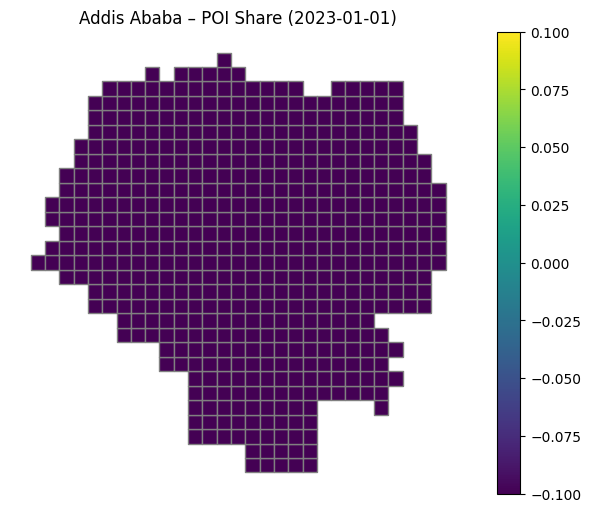

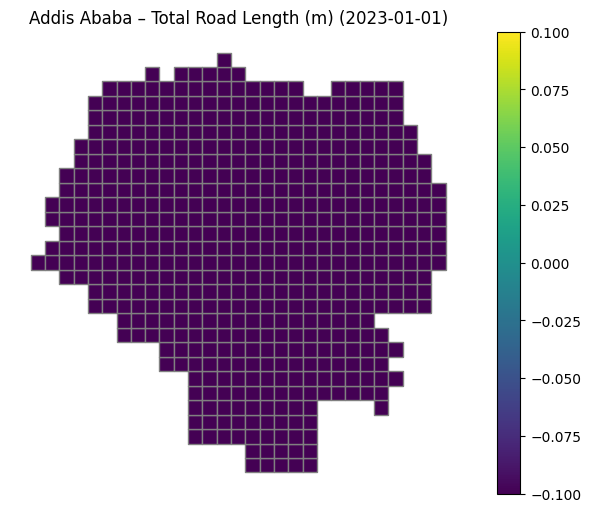

KeyError: 'lu_industrial_area'

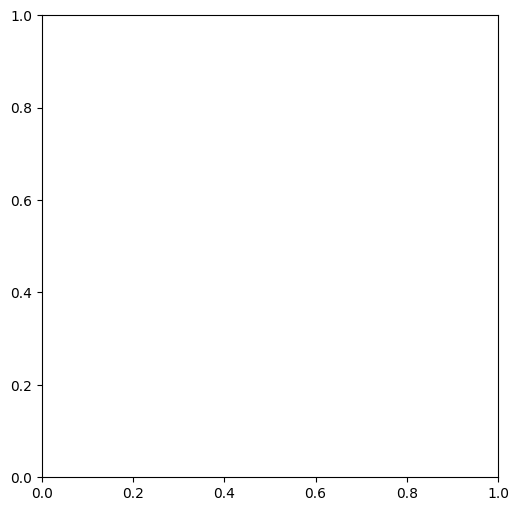

In [11]:
demo_dir = data_root / "demo-data"
#  → “addis-2023-01-01.gpkg” and “baghdad-2023-01-01.gpkg” now exist

# Load the single Addis mesh
gdf_addis = gpd.read_file(demo_dir / "addis-2023-01-01.gpkg")

# POI Share
plot_mesh(
    mesh    = gdf_addis,
    feature = "poi_share",
    title   = "Addis Ababa – POI Share (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

# Road Length
plot_mesh(
    mesh    = gdf_addis,
    feature = "road_len",
    title   = "Addis Ababa – Total Road Length (m) (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

# Industrial Land-use Area
plot_mesh(
    mesh    = gdf_addis,
    feature = "lu_industrial_area",
    title   = "Addis Ababa – Industrial Land-use Area (m²) (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

### Baghdad

PATHS FOR ADDIS ABABA

In [8]:
# -----------------------------------------------------------------------------
# PATHS FOR BAGHDAD
# -----------------------------------------------------------------------------
baghdad_mesh_in  = data_root / "baghdad-empty-mesh-data"
baghdad_mesh_out = data_root / "baghdad-OSM-mesh-data"
baghdad_osm      = data_root / "OSM" / "iraq-latest-free.shp"

ENRICH BAGHDAD — writes ~730 files to baghdad-OSM-mesh-data

In [9]:
batch_write(
    city="baghdad",
    mesh_folder_in=baghdad_mesh_in,
    mesh_folder_out=baghdad_mesh_out,
    osm_shapefile=baghdad_osm,
    relevant_poi=relevant_poi,
    landuse_classes=landuse_classes
)

[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-01.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-02.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-03.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-04.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-05.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-06.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-07.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-08.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-09.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-10.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-11.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-12.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-13.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-14.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-15.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-16.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-17.gpkg
[baghdad]  ✓ W

PLOT DEMO MESH FOR APRIL 2023-01-01 (already written in data/demo-data)

KeyError: 'poi_share'

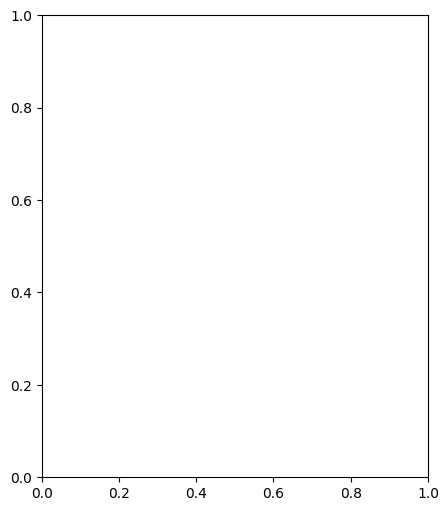

In [12]:
# Load the single Baghdad mesh
gdf_bag = gpd.read_file(demo_dir / "baghdad-2023-01-01.gpkg")

# POI Share
plot_mesh(
    mesh    = gdf_bag,
    feature = "poi_share",
    title   = "Baghdad – POI Share (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

# Road Length
plot_mesh(
    mesh    = gdf_bag,
    feature = "road_len",
    title   = "Baghdad – Total Road Length (m) (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

# Industrial Land-use Area
plot_mesh(
    mesh    = gdf_bag,
    feature = "lu_industrial_area",
    title   = "Baghdad – Industrial Land-use Area (m²) (2023-01-01)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis"
)

## 2 Population Data

### 2.1 Custom Fuctions

In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio
from pathlib import Path

# Global Paths
demo_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/demo-data')
data_dir = Path(r'C:/Users/26454/OneDrive - Imperial College London/Desktop/group design project/Data/World population')


In [3]:
# Function: read tiff files
def read_tiff(filename):
    with rasterio.open(filename) as src:
        band = src.read(1)          # first band
        profile = src.profile       # meta data
        nodata_value = src.nodata   # get nodata (missing)

    return src, band, profile, nodata_value

# Function: Aggregate data within each hexagon
def aggregate_to_mesh(hex_mesh, tiff_path):
    with rasterio.open(tiff_path) as src:
        nodata_val = src.nodata or -99999.0
    stats = zonal_stats(hex_mesh, tiff_path, stats=["sum"], nodata=nodata_val)
    hex_mesh["pop_sum_m"] = [max(0, s["sum"] or 0) for s in stats]
    return hex_mesh

# Load the mesh
os.chdir(demo_dir)
hex_addis_gdf = gpd.read_parquet("addis_ababa_mesh_5km.gpq")
hex_baghdad_gdf = gpd.read_parquet("baghdad_mesh_5km.gpq")

### 2.2 Aggregate Ethiopia - Addis Ababa

In [ ]:
os.chdir(data_dir)

# Aggregate Ethiopia - Addis Ababa
eth_pop_filled_path = os.path.join('Ethiopia - Spatial Distribution of Population (2015-2030)')
eth_filled_tiffs = [f for f in os.listdir(eth_pop_filled_path) if f.lower().endswith('.tif')]
r_eth_filled_paths = [os.path.join(eth_pop_filled_path, f) for f in eth_filled_tiffs] # relative path
# print(r_eth_filled_paths)

# Create a folder to save filled data
output_dir = 'addis_ababa_pop_mesh'
city = 'addis_ababa'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for index, tiff_path in enumerate(r_eth_filled_paths):

    year = eth_filled_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {year}" ) 

    new_hex_mesh = aggregate_to_mesh(hex_addis_gdf, tiff_path)

    # Save as Parquet
    output_file = os.path.join(output_dir, f'{city}_hex_{year}_pop.parquet')
    new_hex_mesh.to_parquet(output_file)

#### Visualization

Demonstrate Addis Ababa population mesh in 2022.

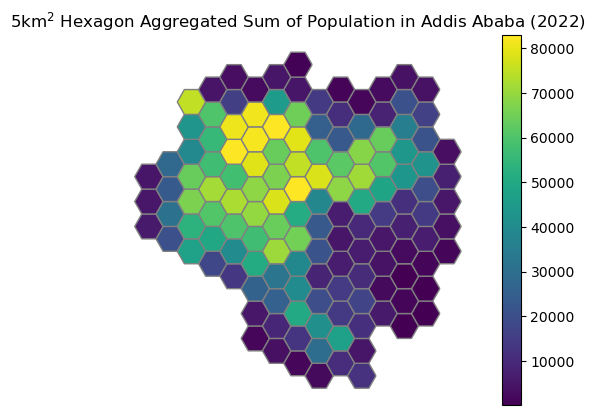

In [11]:
os.chdir(demo_dir)
hex_gdf = gpd.read_parquet('addis_ababa_hex_2022_pop.parquet')

# visual
hex_gdf.plot(column="pop_sum_m", edgecolor="grey", legend=True)
plt.title("5km$^2$ Hexagon Aggregated Sum of Population in Addis Ababa (2022)")
plt.axis("off")
plt.show()

### 2.3 Aggregate Iraq - Baghdad

In [ ]:
os.chdir(data_dir)
# Aggregate Iraq - Baghdad
iraq_pop_filled_path = os.path.join('Iraq - Spatial Distribution of Population (2015-2030)')
iraq_filled_tiffs = [f for f in os.listdir(iraq_pop_filled_path) if f.lower().endswith('.tif')]
r_iraq_filled_paths = [os.path.join(iraq_pop_filled_path, f) for f in iraq_filled_tiffs] # relative path
# print(r_iraq_filled_paths)

# Create a folder to save filled data
output_dir = 'baghdad_pop_mesh'
city = 'baghdad'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for index, tiff_path in enumerate(r_iraq_filled_paths):

    year = iraq_filled_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {year}" ) 

    new_hex_mesh = aggregate_to_mesh(hex_baghdad_gdf, tiff_path)

    # Save as Parquet
    output_file = os.path.join(output_dir, f'{city}_hex_{year}_pop.parquet')
    new_hex_mesh.to_parquet(output_file)

#### Visualization

Demonstrate Baghdad population mesh in 2022.

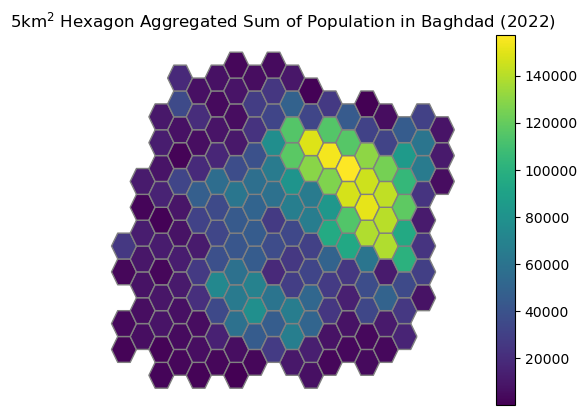

In [8]:
os.chdir(demo_dir)
hex_gdf = gpd.read_parquet('baghdad_hex_2022_pop.parquet')

# visual
hex_gdf.plot(column="pop_sum_m", cmap="viridis", edgecolor="grey", legend=True)
plt.title("5km$^2$ Hexagon Aggregated Sum of Population in Baghdad (2022)")
plt.axis("off")
plt.show()